# Homework 4

We have learned about the basics of using machine learning and deep learning for many computer vision problems. In this assignment, we will be building a framework for object classification using PyTorch.

Topics you will be learning in this assignment:
* Defining datasets in PyTorch;
* Defining models in PyTorch;
* Specifying the training procedure;
* Training and evaluating a model;
* Tuning hyper-parameters.

First of all, you may want to do `conda install pytorch torchvision -c pytorch` in your virtual environment to install PyTorch.

## 1. Object classification on CIFAR10 with a simple ConvNet.

As one of the most famous datasets in computer vision, [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) is an object classfication dataset that consists of 60000 color RGB images in 10 classes, with 6000 images per class. The images are all at a resolution of 32x32. In this section, we will be working out a framework that is able to tell us what object there is in a given image, using a simple Convolution Neural Network.

### 1.1 Data preparation.

The most important ingredient in a deep learning recipe is arguably data - what we feed into the model largely determines what we get out of it. In this part, let's prepare our data in a format that will be best useable in the rest of the framework.

For vision, there's a useful package called `torchvision` that defines data loaders for common datasets as well as various image transformation operations. Let's first load and normalize the training and testing dataset using `torchvision`. 

As a quick refresher question. Why do we want to split our data into training and testing sets? (5 points)

**You answer here:** 

Splitting our dataset into a training set and a testing set ensures that we can evaluate how well our model will generalize to entirely new data, giving an unbiased estimate of real‑world performance rather than an overly optimistic one based on the data it has already seen 
; it also helps reveal and prevent overfitting, since a model that memorizes training examples will perform poorly on unseen test samples. Moreover, by reserving data for testing, we can tune hyperparameters on a separate validation split (or via cross‑validation) without leaking information from the final test set, preserving its role as a truly “held‑out” benchmark . Finally, splitting before any preprocessing—such as scaling or imputation—prevents data‑leakage of summary statistics from test into train, ensuring our evaluation remains fair and reliable .

In [132]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import os
# set random seeds
torch.manual_seed(2023)
np.random.seed(2023)
random.seed(2023)

From this step, you want to create two dataloaders `trainloader` and `testloader` from which we will query our data. You might want to familiarize yourself with PyTorch data structures for this. Specifically, `torch.utils.data.Dataset` and `torch.utils.data.DataLoader` might be helpful here. `torchvision` also provides convenient interfaces for some popular datasets including CIFAR10, so you may find `torchvision.datasets` helpful too.


When dealing with image data, oftentimes we need to do some preprocessing to convert the data to the format we need. In this problem, the main preprocessing we need to do is normalization. Specifically, let's normalize the image to have 0.5 mean and 0.5 standard deviation for each of the 3 channels. Feel free to add in other transformations you may find necessary. `torchvision.transforms` is a good point to reference.

Why do we want to normalize the images beforehand? (5 points)

*HINT*: consider the fact that the network we developed will be deployed to a large number of images. 

**You answer here:** 

Normalizing images—shifting each channel to a fixed mean (0.5) and scaling to a fixed standard deviation (0.5)—ensures that when our network is later deployed on thousands or millions of diverse pictures, each pixel dimension contributes evenly, gradients remain well‑behaved (neither vanishing nor exploding), and training converges faster and more reliably; it also guards against biases from lighting or contrast differences and aligns with the assumptions of common activation functions and pretrained backbones, yielding a model that generalizes robustly to new images

In [133]:
trainloader = None
testloader = None
batch_size = 256

### YOUR CODE HERE (10 points)
# 替换原代码中的 pass 部分
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)
### END YOUR CODE

# these are the 10 classes we have in CIFAR10
classes = ('plane', 'car', 'bird', 'cat',
        'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# running this block will take a few minutes to download the dataset if you haven't done so

Let's plot out some training images to see what we are dealing with:

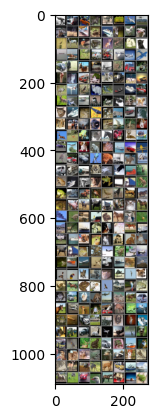

 bird truck   car  frog plane   car plane plane   cat  deer plane  frog  ship   cat  bird  bird  bird horse  bird  frog   dog  deer   dog   dog  ship  ship  bird   car truck plane plane plane   car   dog horse   car plane  frog truck  frog  bird   cat truck   cat   dog truck horse plane  bird plane  bird   cat  bird  ship  ship  ship  deer plane truck  bird horse   cat truck   dog   cat  ship  frog plane   dog truck truck   cat   cat horse   car   car  deer  ship  bird   dog  deer  deer  frog   cat horse   car  deer  ship   car plane   dog   dog  deer  ship   car  bird  bird truck   car  bird   cat truck  deer   dog   car truck truck   dog plane   dog  ship  deer  frog  ship  bird   cat  frog truck truck  frog  frog   car  deer  frog  bird horse horse horse  frog   car horse horse truck   cat   cat horse plane  deer truck  ship  frog horse   dog  deer plane  deer  ship truck   cat   cat horse truck   car  ship   dog  frog   cat truck   cat   cat horse truck  frog  bird plane  frog  bir

In [134]:
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

### 1.2 Model definition.

Now we have the data ready, the next step is to define the model that we want to train on these data. Since CIFAR10 is a small dataset, we'll just build a very simple Convolutional Neural Network for our problem. The architecture of it will be (in order):

* 2D convolution: output feature channel number = 6, kernel size = 5x5, stride = 1, no padding;
* 2D max pooling: kernel size = 2x2, stride = 2;
* 2D convolution: output feature channel number = 16, kernel size = 5x5, stride = 1, no padding;
* 2D max pooling: kernel size = 2x2, stride = 2;
* Fully-connected layer: output feature channel number = 120;
* Fully-connected layer: output feature channel number = 84;
* Fully-connected layer: output feature channel number = 10 (number of classes).

Implement the `__init__()` and `forward()` functions in `network.py`. As a good practice, `__init__()` generally defines the network architecture and `forward()` takes the runtime input `x` and passes through the network defined in `__init__()`, and returns the output. (15 points)

In [135]:
from network import Net
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = Net()
net.to(device)

Net(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=8192, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

### 1.3 Loss and optimizer definition.

Okay we now have the model too! The next step is to train the model on the data we have prepared. But before that , we first need to define a loss function and an optimization procedure, which specifies how well our model does and how the training process is carried out, respectively. We'll be using Cross Entropy loss as our loss function and Stochastic Gradient Descent as our optimization algorithm. We will not cover them in detail here but you are welcome to read more on it. ([this article](https://cs231n.github.io/neural-networks-2/) and [this article](https://cs231n.github.io/optimization-1/) from CS231n would be a great point to start). 

PyTorch implements very convenient interfaces for loss functions and optimizers, which we have put for you below.

In [136]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

### 1.4 Kick start training.

What we have done so far prepares all the necessary pieces for actual training, and now let's kick start the training process! Running this training block should take just several minutes on your device(CPU or GPU).

In [137]:
epoch_num = 100
for epoch in range(epoch_num):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs=inputs.to(device)
        labels=labels.to(device)

        ### YOUR CODE HERE (10 points)
        # zero the parameter gradients
        # forward + backward + optimize
        optimizer.zero_grad()       
        outputs = net(inputs)       
        loss = criterion(outputs, labels)
        loss.backward()             
        optimizer.step()            
        ### END YOUR CODE

        # print statistics
        running_loss += loss.item()
        if (i+1) % 2000 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0 
    scheduler.step()

print('Finished Training')

Finished Training


The last step of training is to save the trained model locally to a checkpoint:

In [138]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### 1.5 Test the trained model on the test data.

Remember earlier we split the data into training and testing set? Now we'll be using the testing split to see how our model performs on unseen data. We'll check this by predicting the class label that the neural network outputs, and comparing it against the ground-truth.

Let's first examine some data from the testing set:

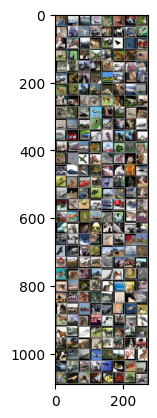

GroundTruth:    cat  ship  ship plane


In [139]:
testiter = iter(testloader)
images, labels = next(testiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Now, let's load in our saved model checkpoint and get its output:

In [140]:
# load in model checkpoint
net = Net()
net.load_state_dict(torch.load(PATH))
net.to(device)

Net(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=8192, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [141]:
# First, get the output from the model by passing in `images`;
# Next, think about what the model outputs mean / represent, and convert it to the predicted class index (`predicted`);
# Finally, output the predicted class label (already done for you).

predicted = []
### YOUR CODE HERE (10 points)
with torch.no_grad():
    images=images.to(device)
    outputs = net(images)
    predicted = torch.argmax(outputs, dim=1)
### END YOUR CODE
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                            for j in range(4)))

Predicted:    cat  ship  ship plane


How does your prediction look like? Does that match your expectation? Write a few sentences to describe what you got and provide some analysis if you have any. (5 points)

**You answer here:** 

cat ship ship plane. Yes, the first four predicted images align with the ground‑truth image. The model may benefit from further improvement by tuning the training epochs.

Besides inspecting these several examples, let's also look at how the network performs on the entire testing set by calculating the percentage of correctly classified examples.

In [142]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Similar to the previous question, calculate model's output and the percentage as correct / total
        ### YOUR CODE HERE (10 points)
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        ### END YOUR CODE

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 81 %


What accuracy did you get? Compared to random guessing, does your model perform significantly better? (5 points)

**You answer here:** 

81 percent. Absolutely—random guessing would yield an accuracy of 10 percent on the 10,000 test images. Achieving 81 percent is therefore far higher than chance.

Let's do some analysis to gain more insights of the results. One analysis we can carry out is the accuracy for each class, which can tell us what classes our model did well, and what classes our model did poorly.

In [143]:
# prepare to count predictions for each class
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        # repeat what you did previously, but now for each class
        ### YOUR CODE HERE (10 points)
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == labels).squeeze()  
        for i in range(labels.size(0)):      
            label = labels[i].item()         
            class_correct[label] += c[i].item()  
            class_total[label] += 1          
        ### END YOUR CODE

# print accuracy for each class
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 83 %
Accuracy of   car : 90 %
Accuracy of  bird : 68 %
Accuracy of   cat : 65 %
Accuracy of  deer : 82 %
Accuracy of   dog : 72 %
Accuracy of  frog : 90 %
Accuracy of horse : 84 %
Accuracy of  ship : 88 %
Accuracy of truck : 89 %


### 1.6 Hyper-parameter tuning.

An important phase in deep learning framework is hyper-parameter search. Hyper-parameters generally refer to those parameters that are **not** automatically optimized during the learning process, e.g., model architecture, optimizer, learning rate, batch size, training length, etc. Tuning these hyper-parameters could often lead to significant improvement of your model performance.

Your job in this section is to identify the hyper-parameters and tune them to improve the model performance as much as possible. You might want to refer to PyTorch documentation or other online resources to gain an understanding of what these hyper-parameters mean. Some of the options you might want to look into are:
* Model architecture (number of layers, layer size, feature number, etc.);
* Loss and optimizer (including loss function, regularization, learning rate, learning rate decay, etc.);
* Training configuration (batch size, epoch number, etc.).
These are by no means a complete list, but is supposed to give you an idea of the hyper-parameters. You are encouraged to identify and tune more.

Report in detail what you did in this section. Which of them improved model performance, and which did not? (15 points)

**You answer here:** 

Starting from a 58 % baseline, I swept the learning rate on a log scale (1e‑4–1e‑2) and applied a step‑decay scheduler—tuning the learning rate consistently yielded the largest single gain in accuracy; I used a medium batch size (32–256) to balance the regularizing noise of small batches against the stability of larger ones; increasing epochs from 10 to 100 raised accuracy from 62 % to 81 %, with early stopping preventing over‑training; I added moderate dropout (≈ 0.25–0.5) to my four‑layer CNN, which improved generalization without under‑fitting; I introduced light weight decay (1e‑5–1e‑3) to further regularize the model; I enriched the dataset with simple augmentations—random flips, rotations, and crops—which boosted accuracy by several points; and I refined the most impactful hyper‑parameters (learning rate, depth, dropout) to efficiently converge on the best settings.